In [1]:
import xarray as xr
import numpy as np
import cmocean as cm
import os
import pandas as pd
import pylab as plt
import cmocean as cm
%matplotlib inline

In [2]:
import matplotlib.ticker as mticker

In [3]:
from dask.distributed import Client

In [4]:
c=Client()
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 96.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35303,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 96.00 GiB
Comm: tcp://10.6.72.24:44579,Total threads: 4
Dashboard: /proxy/36277/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:32963,


In [5]:
import cartopy.crs as ccrs
import cartopy.feature as feature
land_50m = feature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='#DFD1AF',
                                        linewidth=0.2)

# Satellite

In [6]:
path="/g/data/ua8/CMEMS_SeaLevel/v2019/*/*.nc"
data=xr.open_mfdataset(path,chunks={'latitude': 720, 'longitude': 1440, 'time': 5},parallel=True)

In [7]:
ke = (1/2)*(data.ugos**2+data.vgos**2)

In [8]:
u_prime = (data.ugos - data.ugos.mean('time')).rename({'latitude':'lat','longitude':'lon'})
v_prime = (data.vgos - data.vgos.mean('time')).rename({'latitude':'lat','longitude':'lon'})

In [9]:
eke = (1/2)*(u_prime**2+v_prime**2)

In [10]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/eddy/satellite_u_*.nc'
u_eddy=xr.open_mfdataset(path,chunks={'lat': 720, 'lon': 1440, 'time': 10})
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/eddy/satellite_v_*.nc'
v_eddy=xr.open_mfdataset(path,chunks={'lat': 720, 'lon': 1440, 'time': 10})

In [11]:
trke = (1/2)*((u_prime-u_eddy.u_eddy)**2+(v_prime-v_eddy.v_eddy)**2)

In [12]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/satellite_KE_*.nc'
KE=xr.open_mfdataset(path,chunks={'latitude': 720//4, 'longitude': 1440//4, 'time': 10})

In [13]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/satellite_EKE_field_*.nc'
EKE=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [14]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/eddy/satellite_TEKE_eddy*.nc'
TEKE=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [15]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/residual/satellite_TEKE_res_*.nc'
TRKE=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [16]:
path='/g/data/v45/jm5970/trackeddy_output/AVISO+/post-processing/diff/satellite_TEKE_cross_*.nc'
TRKE_c=xr.open_mfdataset(path,chunks={'lat': 720//4, 'lon': 1440//4, 'time': 10})

In [17]:
output_data = '/home/156/jm5970/hh5/climatology_V2/'

In [18]:
sKE = KE.rename({'__xarray_dataarray_variable__':'KE','latitude':'lat','longitude':'lon'}).sel(time='2017-01-01').where(abs(EKE.lat)>5)
sEKE = EKE.rename({'EKE_eddy':'EKE'}).sel(time='2017-01-01').where(abs(EKE.lat)>5)
sCEKE = TEKE.rename({'EKE_eddy':'CEKE'}).sel(time='2017-01-01').where(abs(EKE.lat)>5)
sREKE = TRKE.rename({'EKE_res':'REKE'}).sel(time='2017-01-01').where(abs(EKE.lat)>5)

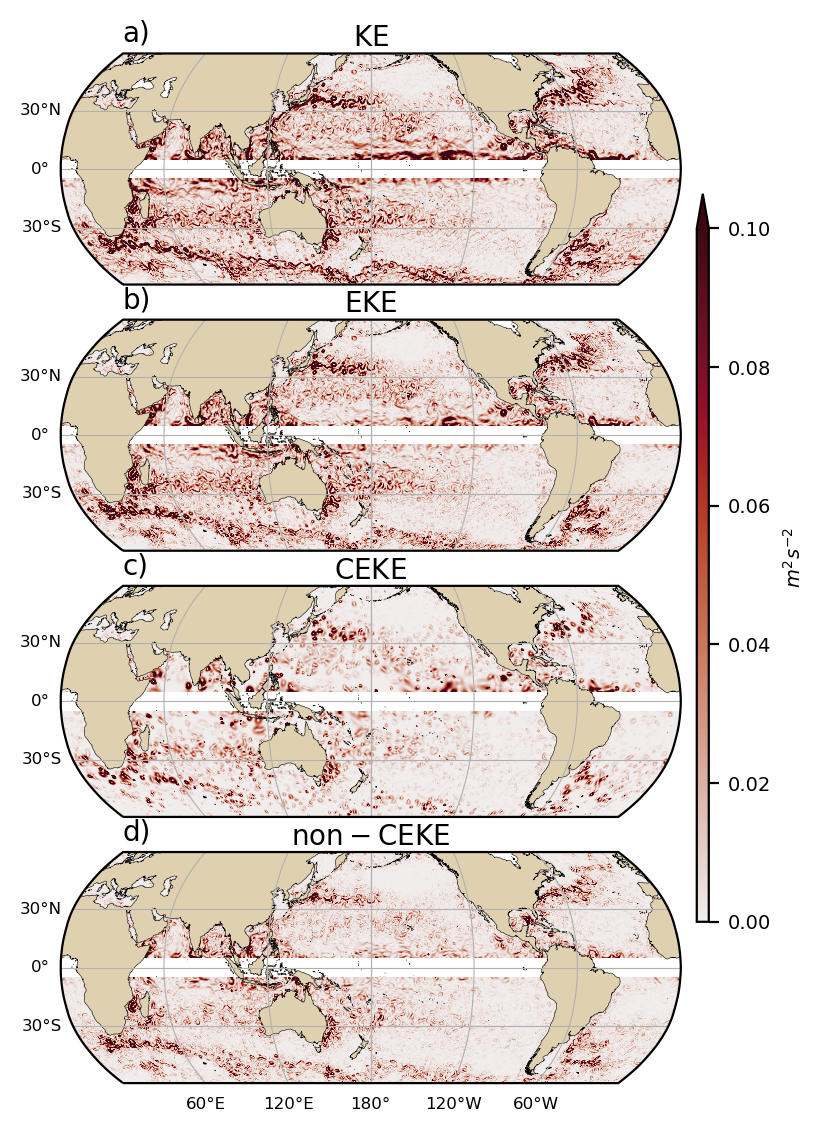

In [20]:
cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

fig = plt.figure(figsize=(4, 7),dpi=200)
ax1=fig.add_subplot(4, 1, 1, projection = ccrs.Robinson(central_longitude=180))
sKE.KE.plot(ax=ax1,transform =ccrs.PlateCarree(),
                          rasterized=True,cmap=cm.cm.amp,
                          vmin=0,vmax=0.1, add_colorbar = False)

ax1.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax1.add_feature(land_50m)
ax1.set_title(r'$\mathrm{KE}$',fontsize=10,y=0.96)

ax2=fig.add_subplot(4, 1, 2, projection = ccrs.Robinson(central_longitude=180))
sEKE.EKE.plot(ax=ax2,transform =ccrs.PlateCarree(),
                                rasterized=True,cmap=cm.cm.amp,
                                vmin=0,vmax=0.1, add_colorbar = False)

ax2.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax2.add_feature(land_50m)
ax2.set_title(r'$\mathrm{EKE}$',fontsize=10,y=0.96)

ax3=fig.add_subplot(4, 1, 3, projection = ccrs.Robinson(central_longitude=180))
sCEKE.CEKE.plot(ax=ax3,transform =ccrs.PlateCarree(),
                                rasterized=True,cmap=cm.cm.amp,
                                vmin=0,vmax=0.1, add_colorbar = False)

ax3.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax3.add_feature(land_50m)
ax3.set_title(r'$\mathrm{CEKE}$',fontsize=10,y=0.96)

ax4=fig.add_subplot(4, 1, 4, projection = ccrs.Robinson(central_longitude=180))
clm  = sREKE.REKE.plot(ax=ax4,transform =ccrs.PlateCarree(),
                                rasterized=True,cmap=cm.cm.amp,
                                vmin=0,vmax=0.1, add_colorbar = False)

ax4.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax4.add_feature(land_50m)
ax4.set_title(r'$\mathrm{non-CEKE}$',fontsize=10,y=0.96)

cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.52])
cbar=fig.colorbar(clm, cax=cbar_ax,orientation='vertical',extend='max')
cbar.set_label('$m^{2} s^{-2}$', rotation=90, fontsize=7)
cbar.ax.tick_params(labelsize=7) 

ax1.text(0.1,1.05,r'a)',fontsize=10,transform=ax1.transAxes)
ax2.text(0.1,1.05,r'b)',fontsize=10,transform=ax2.transAxes)
ax3.text(0.1,1.05,r'c)',fontsize=10,transform=ax3.transAxes)
ax4.text(0.1,1.05,r'd)',fontsize=10,transform=ax4.transAxes)

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

plt.subplots_adjust(wspace=0.05, hspace=0.03)
plt.savefig('./Figure_1_snapshot_ke_maps_satellite_large.pdf',dpi=300,bbox_inches='tight')

In [21]:
output_data = '/home/156/jm5970/hh5/climatology_V2/'

In [22]:
MKE = xr.open_dataset(output_data+'./MKE_climatology.nc').rename({'__xarray_dataarray_variable__':'MKE','latitude':'lat','longitude':'lon'})/10000
MEKE = xr.open_dataset(output_data+'./MEKE_climatology.nc').rename({'EKE_eddy':'MEKE'})
MCEKE = xr.open_dataset(output_data+'./MTEKE_climatology.nc').rename({'EKE_eddy':'MCEKE'})
MREKE = xr.open_dataset(output_data+'./MTRKE_climatology.nc').rename({'EKE_res':'MREKE'})
MREKE_c = xr.open_dataset(output_data+'./MTRKE_c_climatology.nc').rename({'TEKE_c':'MREKE_c'})

In [23]:
MKE = MKE.where(abs(MKE.lat)>5)
MEKE = MEKE.where(abs(MEKE.lat)>5)
MCEKE = MCEKE.where(abs(MCEKE.lat)>5)
MREKE = MREKE.where(abs(MREKE.lat)>5)
MREKE_c = MREKE_c.where(abs(MREKE_c.lat)>5)

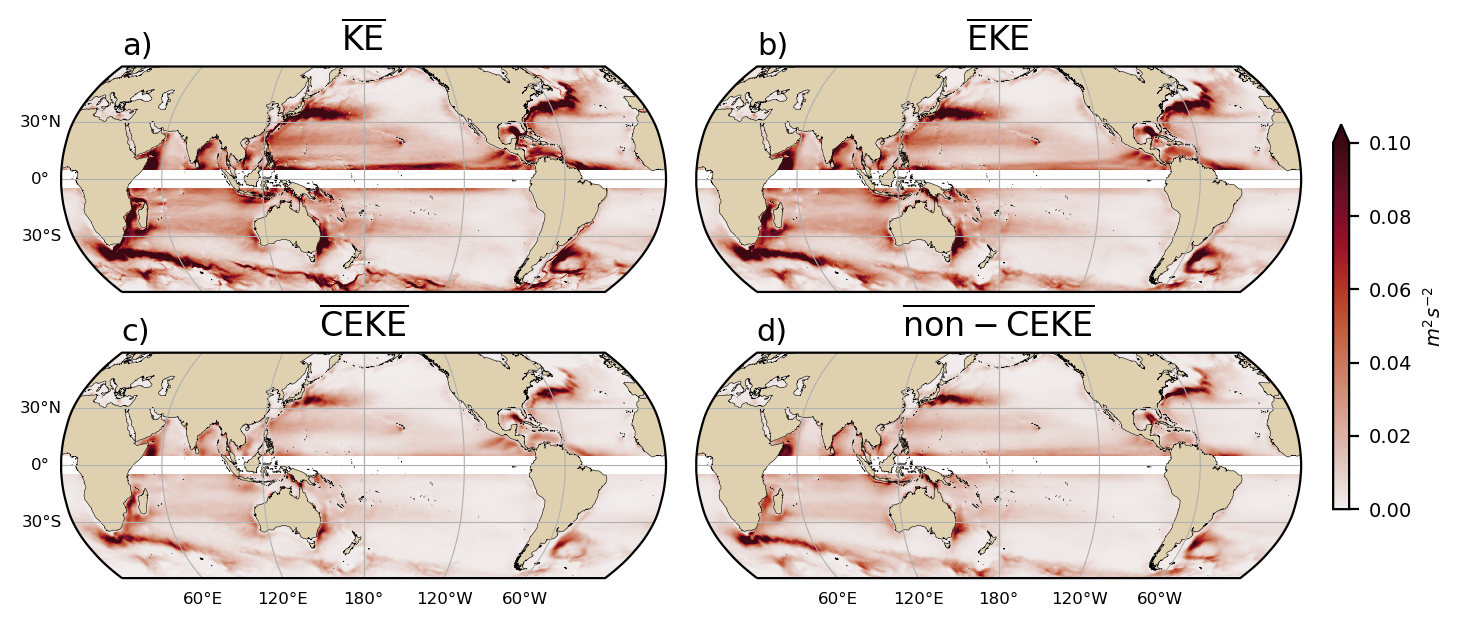

In [24]:
cbar_kwargs=dict(pad=0.15, shrink=1, label=r'')

fig = plt.figure(figsize=(8, 3.7),dpi=200)
ax1=fig.add_subplot(2, 2, 1, projection = ccrs.Robinson(central_longitude=180))
MKE.MKE.plot(ax=ax1,transform =ccrs.PlateCarree(),
                          rasterized=True,cmap=cm.cm.amp,
                          vmin=0,vmax=0.1, add_colorbar = False)

ax1.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax1.add_feature(land_50m)
ax1.set_title(r'$\overline{\mathrm{KE}}$')

ax2=fig.add_subplot(2, 2, 2, projection = ccrs.Robinson(central_longitude=180))
MEKE.MEKE.plot(ax=ax2,transform =ccrs.PlateCarree(),
                                rasterized=True,cmap=cm.cm.amp,
                                vmin=0,vmax=0.1, add_colorbar = False)

ax2.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax2.add_feature(land_50m)
ax2.set_title(r'$\overline{\mathrm{EKE}}$')

ax3=fig.add_subplot(2, 2, 3, projection = ccrs.Robinson(central_longitude=180))
MCEKE.MCEKE.plot(ax=ax3,transform =ccrs.PlateCarree(),
                                rasterized=True,cmap=cm.cm.amp,
                                vmin=0,vmax=0.1, add_colorbar = False)

ax3.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax3.add_feature(land_50m)
ax3.set_title(r'$\overline{\mathrm{CEKE}}$')

ax4=fig.add_subplot(2, 2, 4, projection = ccrs.Robinson(central_longitude=180))
clm  = MREKE.MREKE.plot(ax=ax4,transform =ccrs.PlateCarree(),
                                rasterized=True,cmap=cm.cm.amp,
                                vmin=0,vmax=0.1, add_colorbar = False)

ax4.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax4.add_feature(land_50m)
ax4.set_title(r'$\overline{\mathrm{non-CEKE}}$')

cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.52])
cbar=fig.colorbar(clm, cax=cbar_ax,orientation='vertical',extend='max')
cbar.set_label('$m^{2} s^{-2}$', rotation=90, fontsize=7)
cbar.ax.tick_params(labelsize=7) 

ax1.text(0.1,1.05,r'a)',fontsize=11,transform=ax1.transAxes)
ax2.text(0.1,1.05,r'b)',fontsize=11,transform=ax2.transAxes)
ax3.text(0.1,1.05,r'c)',fontsize=11,transform=ax3.transAxes)
ax4.text(0.1,1.05,r'd)',fontsize=11,transform=ax4.transAxes)

gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.bottom_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.left_labels = False
gl.right_labels = False
gl.bottom_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

gl = ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,linewidth=0.4)
gl.xlabel_style = {'size': 6}
gl.ylabel_style = {'size': 6}
gl.rotate_labels = False
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180,181,60))
gl.ylocator = mticker.FixedLocator(np.arange(-30,60,30))

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('./Figure_2_mean_ke_maps_satellite.pdf',dpi=300,bbox_inches='tight')